In [38]:
import os

complete_ChEMBL25_csv_path = os.environ["DATA"] + "/00_datasets/ChEMBL25/complete_ChEMBL.csv"
QM9_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/QM9.smi"
fig_path = os.environ["FIGURES"] + "/00_datasets/ChEMBL_QM9_mol_size_dist.png"

In [6]:
import csv
from rdkit.Chem import MolFromSmiles
from evomol.molgraphops.molgraph import MolGraph
from tqdm import tqdm

def load_dataset_smiles(path):
    smi_list = []
    
    with open(path, "r") as f:
        reader = csv.reader(f, delimiter=";")

        for i, row in enumerate(tqdm(list(reader))):
            if i != 0:
                smi_list.append(MolGraph(MolFromSmiles(row[30])).to_aromatic_smiles())

    return smi_list

def load_dataset_smiles_QM9(path):
    smi_list = []
    
    with open(path, "r") as f:
        reader = csv.reader(f)

        for i, row in enumerate(tqdm(list(reader))):
                smi_list.append(MolGraph(MolFromSmiles(row[0])).to_aromatic_smiles())

    return smi_list

In [8]:
smi_list = load_dataset_smiles(complete_ChEMBL25_csv_path)

100%|██████████| 1817796/1817796 [28:25<00:00, 1065.62it/s]


In [7]:
smi_list_QM9 = load_dataset_smiles_QM9(QM9_path)

100%|██████████| 133885/133885 [00:30<00:00, 4345.22it/s]


In [26]:
print("# molecules : " + str(len(smi_list)))

# molecules : 1817795


In [12]:
from rdkit.Chem.Lipinski import HeavyAtomCount

def get_mol_sizes(smi_list):
    mol_sizes = []
    for smi in tqdm(smi_list):
        mol_sizes.append(HeavyAtomCount(MolFromSmiles(smi)))
    return mol_sizes

In [13]:
mol_sizes = get_mol_sizes(smi_list)

100%|██████████| 1817795/1817795 [04:25<00:00, 6837.90it/s]


In [11]:
mol_sizes_QM9 = get_mol_sizes(smi_list_QM9)

100%|██████████| 133885/133885 [00:04<00:00, 29210.52it/s]


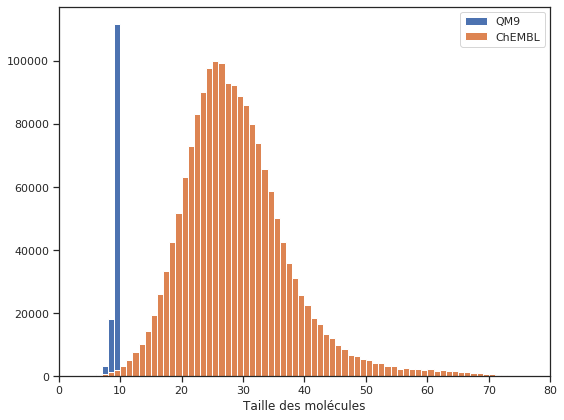

In [51]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
import numpy as np

data = {
    "data": mol_sizes_QM9 + mol_sizes,
    "Jeu de données": np.concatenate([np.full((len(mol_sizes_QM9),), 'QM9'), np.full((len(mol_sizes),), 'ChEMBL')])
}

plt.figure(figsize=(8, 6))
plt.xlabel("Taille des molécules")
plt.hist(mol_sizes_QM9, label="QM9", bins=np.arange(80))
plt.hist(mol_sizes, label="ChEMBL", bins=np.arange(80))
plt.plot([27], [0])
plt.xlim(0, 80)
plt.legend()
plt.savefig(fig_path, dpi=250)
plt.tight_layout()
plt.show()


In [52]:
import numpy as np
np.mean(mol_sizes)

28.45803954791382

In [16]:
np.median(mol_sizes)

27.0

In [19]:
np.max(mol_sizes)

139

In [56]:
np.min(mol_sizes)

0

In [60]:
np.argwhere(np.array(mol_sizes)==1)

array([[  23184],
       [  29043],
       [  65917],
       [  69374],
       [  73937],
       [  97315],
       [ 147844],
       [ 187723],
       [ 267920],
       [ 336574],
       [ 421278],
       [ 464250],
       [ 474693],
       [ 809358],
       [ 954546],
       [ 963408],
       [1027657],
       [1038927],
       [1157586],
       [1484820],
       [1502514],
       [1550350],
       [1611731],
       [1668347],
       [1671538]])

In [65]:
smi_list[np.argwhere(np.array(mol_sizes)==1)[5][0]]

'N'

In [27]:
from rdkit.Chem.Descriptors import NumRadicalElectrons
from rdkit.Chem import MolFromSmiles
from evomol.molgraphops.molgraph import MolGraph

def is_radical(smi):
    return NumRadicalElectrons(MolFromSmiles(smi)) > 0

def contains_charge(smi):
    """
    Checking if the given molecule contains charges
    """
    
    mol = MolFromSmiles(smi)
    for at in mol.GetAtoms():
        if at.GetFormalCharge() != 0:
            return True
    
    return False

def is_CNOF(smi):
    
    valid_atom_types = ["C", "O", "N", "F", "H"]
    
    molgraph = MolGraph(MolFromSmiles(smi))
    
    # Extracting atom types:
    atom_types = set(molgraph.get_atom_types())
    
    # Checking that all atom types are valid
    for at_type in atom_types:
        if at_type not in valid_atom_types:
            return False
        
    return True


In [38]:
def perform_counts(smiles_list):
    
    n_mol_radicals = 0
    n_mol_contain_charges = 0
    n_mol_CNOF = 0
    n_mol_total = 0
    
    atom_types_count = {}
    
    for smi in tqdm(smiles_list):
        
        n_mol_total += 1
        
        if is_radical(smi):
            n_mol_radicals += 1
            
        if contains_charge(smi):
            n_mol_contain_charges += 1
        
        if is_CNOF(smi):
            n_mol_CNOF += 1
                
        molgraph = MolGraph(MolFromSmiles(smi))
        atom_types = set(molgraph.get_atom_types())
            
        for atom_type in atom_types:
            if atom_type in atom_types_count:
                atom_types_count[atom_type] += 1
            else:
                atom_types_count[atom_type] = 1
                
    return n_mol_radicals, n_mol_contain_charges, n_mol_CNOF, n_mol_total, atom_types_count

In [39]:
n_mol_radicals, n_mol_contain_charges, n_mol_CNOF, n_mol_total, atom_types_count = perform_counts(smi_list)

100%|██████████| 1817795/1817795 [59:28<00:00, 509.43it/s] 


In [40]:
n_mol_radicals

432

In [41]:
n_mol_contain_charges

128658

In [42]:
n_mol_CNOF

922494

In [43]:
n_mol_total

1817795

In [44]:
atom_types_count

{'S': 573337,
 'N': 1687143,
 'Cl': 350082,
 'C': 1817632,
 'O': 1692269,
 'Br': 81771,
 'F': 346033,
 'P': 28015,
 'I': 14294,
 'Ca': 85,
 'Na': 6881,
 'Al': 4,
 'K': 871,
 'B': 178,
 'Zn': 102,
 'Mg': 24,
 'H': 494,
 'Li': 359,
 'Ag': 10,
 'Ba': 4,
 'Sr': 4,
 'Bi': 1}

In [54]:
d = {'S': 573337,
 'N': 1687143,
 'Cl': 350082,
 'C': 1817632,
 'O': 1692269,
 'Br': 81771,
 'F': 346033,
 'P': 28015,
 'I': 14294,
 'Ca': 85,
 'Na': 6881,
 'Al': 4,
 'K': 871,
 'B': 178,
 'Zn': 102,
 'Mg': 24,
 'H': 494,
 'Li': 359,
 'Ag': 10,
 'Ba': 4,
 'Sr': 4,
 'Bi': 1}

In [55]:
sorted(d, key=d.get)


['Bi',
 'Al',
 'Ba',
 'Sr',
 'Ag',
 'Mg',
 'Ca',
 'Zn',
 'B',
 'Li',
 'H',
 'K',
 'Na',
 'I',
 'P',
 'Br',
 'F',
 'Cl',
 'S',
 'N',
 'O',
 'C']